# hs removing and adding layers to pretrained models

## 1 define model

In [1]:
import os
import sys
import glob
import random
import datetime
import warnings


import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
import skimage
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

Using TensorFlow backend.


In [3]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [ ]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

## load the model with pre-trained weights

In [4]:
model = load_model('model-dsbowl2018-1.h5', custom_objects={'mean_iou': mean_iou})
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 128, 128, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (

## do a prediction for compariosn later

In [6]:
# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = './data/stage1_train/'
TEST_PATH = './data/stage1_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42

# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [7]:
# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

Getting and resizing test images ... 


100%|██████████| 65/65 [00:00<00:00, 103.22it/s]


In [8]:
preds_test = model.predict(X_test[0:1,:,:,:], verbose=1)
preds_test.shape

1/1 [==============================] - 1s 917ms/step


(1, 128, 128, 1)

In [12]:
preds_test[0,1,1,0]

0.086694457

### in above, preds_test is a probability map, where the value for each pixel shows the prob that it is a cell neclei

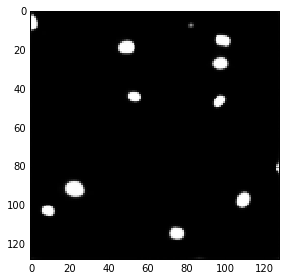

In [9]:
imshow(np.squeeze(preds_test))
plt.show()

### we can convert above probability map to binary with a threshold

0


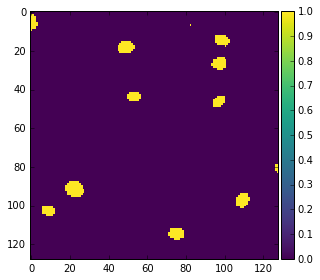

In [14]:
preds_test_t = (preds_test > 0.5).astype(np.uint8)
print(preds_test_t[0,1,1,0])
imshow(np.squeeze(preds_test_t))
plt.show()

## getting the trained layers

### There are two ways of accessing layers using get_layer and by defining a custom dict:

#### 1: using get_layer:

In [ ]:
model.layers

In [15]:
theOneToTheLastLayerWithPreTrainedWeights = model.get_layer('conv2d_18')
theOneToTheLastLayerWithPreTrainedWeights

In [16]:
theOutputOfOneTotheLastLayer = model.get_layer('conv2d_18').output
theOutputOfOneTotheLastLayer

<tf.Tensor 'conv2d_18/Elu:0' shape=(?, 128, 128, 16) dtype=float32>

#### 2: Defining a custom dictionary of layers:

In [18]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])
[layer.name for layer in model.layers]

['input_1',
 'lambda_1',
 'conv2d_1',
 'dropout_1',
 'conv2d_2',
 'max_pooling2d_1',
 'conv2d_3',
 'dropout_2',
 'conv2d_4',
 'max_pooling2d_2',
 'conv2d_5',
 'dropout_3',
 'conv2d_6',
 'max_pooling2d_3',
 'conv2d_7',
 'dropout_4',
 'conv2d_8',
 'max_pooling2d_4',
 'conv2d_9',
 'dropout_5',
 'conv2d_10',
 'conv2d_transpose_1',
 'concatenate_1',
 'conv2d_11',
 'dropout_6',
 'conv2d_12',
 'conv2d_transpose_2',
 'concatenate_2',
 'conv2d_13',
 'dropout_7',
 'conv2d_14',
 'conv2d_transpose_3',
 'concatenate_3',
 'conv2d_15',
 'dropout_8',
 'conv2d_16',
 'conv2d_transpose_4',
 'concatenate_4',
 'conv2d_17',
 'dropout_9',
 'conv2d_18',
 'conv2d_19']

In [19]:
layer_names = [layer.name for layer in model.layers]

In [20]:
theOneToTheLastLayerWithPreTrainedWeights = layer_dict['conv2d_18']
theOneToTheLastLayerWithPreTrainedWeights

In [21]:
theOutputOfOneTotheLastLayer = layer_dict['conv2d_18'].output
theOutputOfOneTotheLastLayer

<tf.Tensor 'conv2d_18/Elu:0' shape=(?, 128, 128, 16) dtype=float32>

## <font color='red'> Creating a new model from the pretrained layers of the base model but without the last layer:</font>

In [22]:
new_model1 = Model(model.input, theOutputOfOneTotheLastLayer)
new_model1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 128, 128, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (

## <font color='red'> Adding the last trained layer of orig model to a new new model (for comparison):</font>

In [27]:
y = model.get_layer('conv2d_19')(theOutputOfOneTotheLastLayer)
new_model2 = Model(model.input, y)
new_model2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 128, 128, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (

In [25]:
preds_test_new = new_model2.predict(X_test[0:1,:,:,:], verbose=1)
preds_test_new.shape

1/1 [==============================] - 0s 120ms/step


(1, 128, 128, 1)

In [26]:
preds_test[0,1,1,0]

0.086694457

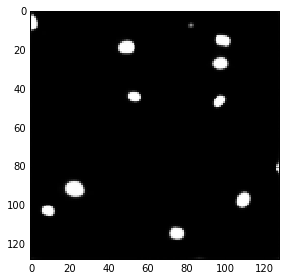

In [37]:
imshow(np.squeeze(preds_test))
plt.show()

## <font color='red'> In above I successfully combine two pre-trained models from the original (model) into a new model</font>

In [32]:
z = layer_dict['conv2d_18'].output
z

<tf.Tensor 'conv2d_18/Elu:0' shape=(?, 128, 128, 16) dtype=float32>

In [45]:
newUntrainedLayer = Conv2D(1, (1, 1), activation='sigmoid', name='hsConv') (z)
newUntrainedLayer

<tf.Tensor 'hsConv_2/Sigmoid:0' shape=(?, 128, 128, 1) dtype=float32>

<font color='red'> Note, in above if you dont set a custom name you get a duplicated name error. Because keras will name the new con2d layer you just created conv2d_4 and there is a con2d_4 already in the graph</font>

In [46]:
new_model3 = Model(model.input, newUntrainedLayer)
new_model3.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 128, 128, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (

In [47]:
preds_test_new = new_model2.predict(X_test[0:1,:,:,:], verbose=1)
preds_test_new.shape

1/1 [==============================] - 0s 159ms/step


(1, 128, 128, 1)

0.0866945


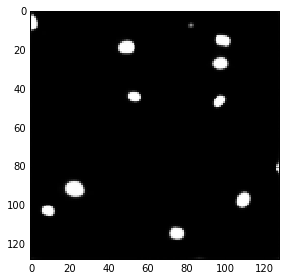

In [48]:
print(preds_test[0,1,1,0])
imshow(np.squeeze(preds_test))
plt.show()

# hs from an online tutorial

Keeping in mind that convnet features are more generic in early layers and more original-dataset-specific in later layers, here are some common rules of thumb for navigating the 4 major scenarios:

# 1. New dataset is small and similar to original dataset:
There is a problem of over-fitting, if we try to train the entire network. Since the data is similar to the original data, we expect higher-level features in the ConvNet to be relevant to this dataset as well. Hence, the best idea might be to train a linear classifier on the CNN codes.

So lets freeze all the VGG19 layers and train only the classifier

In [ ]:
for layer in model.layers:
   layer.trainable = False
#Now we will be training only the classifiers (FC layers)

In case if you want to freeze the first few layers as these layers will be detecting edges and blobs, you can freeze them by using the following code.

In [ ]:
for layer in model.layers[:5]:
   layer.trainable = False.
# Here I am freezing the first 5 layers 

# 2. New dataset is large and similar to the original dataset
Since we have more data, we can have more confidence that we won’t overfit if we were to try to fine-tune through the full network.

In [ ]:
for layer in model.layers:
   layer.trainable = True
#The default is already set to True. I have mentioned it here to make things clear.

# Simple implementation using Keras:

In [1]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

Using TensorFlow backend.


In [2]:
img_width, img_height = 256, 256
train_data_dir = "data/train"
validation_data_dir = "data/val"
nb_train_samples = 4125
nb_validation_samples = 466 
batch_size = 16
epochs = 50

In [ ]:
model = applications.VGG19(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))

In [ ]:
# Freeze the layers which you don't want to train. Here I am freezing the first 5 layers.
for layer in model.layers[:5]:
    layer.trainable = False

In [ ]:
#Adding custom Layers 
x = model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(16, activation="softmax")(x)

In [ ]:
# creating the final model 
model_final = Model(input = model.input, output = predictions)

In [ ]:
# compile the model 
model_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])

In [ ]:
# Initiate the train and test generators with data Augumentation 
train_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
fill_mode = "nearest",
zoom_range = 0.3,
width_shift_range = 0.3,
height_shift_range=0.3,
rotation_range=30)


test_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
fill_mode = "nearest",
zoom_range = 0.3,
width_shift_range = 0.3,
height_shift_range=0.3,
rotation_range=30)

In [ ]:
train_generator = train_datagen.flow_from_directory(
train_data_dir,
target_size = (img_height, img_width),
batch_size = batch_size, 
class_mode = "categorical")


validation_generator = test_datagen.flow_from_directory(
validation_data_dir,
target_size = (img_height, img_width),
class_mode = "categorical")

In [ ]:
# Save the model according to the conditions  
checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')

In [ ]:
# Train the model 
model_final.fit_generator(
train_generator,
samples_per_epoch = nb_train_samples,
epochs = epochs,
validation_data = validation_generator,
nb_val_samples = nb_validation_samples,
callbacks = [checkpoint, early])


# 3. New dataset is small but very different from the original dataset
Since the dataset is very small, We may want to extract the features from the earlier layer and train a classifier on top of that. This requires a little bit of knowledge on h5py.

In [ ]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

In [ ]:
img_width, img_height = 256, 256

In [ ]:
### Build the network 
img_input = Input(shape=(256, 256, 3))
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

# Block 2
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

model = Model(input = img_input, output = x)

model.summary()

In [ ]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])
[layer.name for layer in model.layers]
"""
['input_1',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool']
"""

In [ ]:
import h5py
weights_path = 'vgg19_weights.h5' # ('https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg19_weights_tf_dim_ordering_tf_kernels.h5)
f = h5py.File(weights_path)

list(f["model_weights"].keys())
"""
['block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_conv4',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_conv4',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_conv4',
 'block5_pool',
 'dense_1',
 'dense_2',
 'dense_3',
 'dropout_1',
 'global_average_pooling2d_1',
 'input_1']
"""

In [ ]:
# list all the layer names which are in the model.
layer_names = [layer.name for layer in model.layers]

In [ ]:
"""
# Here we are extracting model_weights for each and every layer from the .h5 file
>>> f["model_weights"]["block1_conv1"].attrs["weight_names"]
array([b'block1_conv1/kernel:0', b'block1_conv1/bias:0'], 
      dtype='|S21')
# we are assiging this array to weight_names below 
>>> f["model_weights"]["block1_conv1"]["block1_conv1/kernel:0]
<HDF5 dataset "kernel:0": shape (3, 3, 3, 64), type "<f4">
# The list comprehension (weights) stores these two weights and bias of both the layers 
>>>layer_names.index("block1_conv1")
1
>>> model.layers[1].set_weights(weights)
# This will set the weights for that particular layer.
With a for loop we can set_weights for the entire network.
"""
for i in layer_dict.keys():
    weight_names = f["model_weights"][i].attrs["weight_names"]
    weights = [f["model_weights"][i][j] for j in weight_names]
    index = layer_names.index(i)
    model.layers[index].set_weights(weights)

In [ ]:
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import itertools
import glob

features = []
for i in tqdm(files_location):
        im = cv2.imread(i)
        im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (256, 256)).astype(np.float32) / 255.0
        im = np.expand_dims(im, axis =0)
        outcome = model_final.predict(im)
        features.append(outcome)
        
## collect these features and create a dataframe and train a classfier on top of it.

The above code should help. It will extract the “block2_pool” features. In general this is not helpful as this layer has (64*64*128) features and training a classifier on top of it might not help us exactly. We can add a few FC layers and train a neural network on top of it. That should be straight forward.

Add few FC layers and output layer.
Set the weights for earlier layers and freeze them.
Train the network.
4. New dataset is large and very different from the original dataset.
This is straight forward. since you have large dataset, you can design your own network or use the existing ones.

Train the network using random initialisations or use the pre-trained network weights as initialisers. The second one is generally preferred.
If you are using a different network or making small modification here and there for the existing network, Be careful with the naming conventions.